In [118]:
import pandas as pd
import numpy as np
import json
import ast
from tqdm import tqdm
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
from neo4j import GraphDatabase, basic_auth
from dotenv import load_dotenv


In [97]:
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection    
    if union == 0:
        return 0.0
    else:
        jaccard_similarity = intersection / union
        return jaccard_similarity
    
def extract_answer(text):
    pattern = r'{[^{}]*}'
    match = re.search(pattern, text)
    if match:
        return match.group()
    else:
        return None
    
def extract_by_splitting(text):
    compound_list = text.split(':')[1].split("Diseases")[0].split("], ")[0]+"]"
    disease_list = text.split(':')[-1].split("}")[0]
    resp = {}
    resp["Compounds"] = ast.literal_eval(compound_list)
    resp["Diseases"] = ast.literal_eval(disease_list)
    return resp
    

In [92]:
DATA_PATH = "../../../data/analysis_results/gpt_4_node_retrieval_rag_based_drug_reporposing_questions.csv"


In [93]:
data = pd.read_csv(DATA_PATH)


In [99]:
%%time

llm_performance_list = []
for index, row in tqdm(data.iterrows()):
    cmp_gt = ast.literal_eval(row["compound_groundTruth"])
    disease_gt = ast.literal_eval(row["disease_groundTruth"])
    try:
        llm_answer = json.loads(extract_answer(row["llm_answer"]))
    except:
        llm_answer = extract_by_splitting(row["llm_answer"])
    cmp_llm = llm_answer["Compounds"]
    disease_llm = llm_answer["Diseases"]
    cmp_similarity = jaccard_similarity(cmp_gt, cmp_llm)
    disease_similarity = jaccard_similarity(disease_gt, disease_llm)
    llm_performance = np.mean([cmp_similarity, disease_similarity])
    llm_performance_list.append(llm_performance)


143it [00:00, 3832.15it/s]

CPU times: user 40.7 ms, sys: 3.57 ms, total: 44.3 ms
Wall time: 42.1 ms


In [119]:
%%time


load_dotenv(os.path.join(os.path.expanduser('~'), '.neo4j_config.env'))
USER = os.environ.get('SPOKE_USER')
PSW = os.environ.get('SPOKE_PSW')
URI = os.environ.get('SPOKE_URI')

DISEASE_QUERY = """
    MATCH(d:Disease) 
    RETURN DISTINCT d.name AS d_name     
"""

COMPOUND_QUERY = """
    MATCH(d:Compound) 
    RETURN DISTINCT c.name AS c_name     
"""


auth = basic_auth(USER, PSW)
sdb = GraphDatabase.driver(URI, auth=auth)

disease_list = []
with sdb.session() as session:
    with session.begin_transaction() as tx:
        result = tx.run(DISEASE_QUERY)
        for row in result:
            disease_list.append(row["d_name"])
            
compound_list = []
with sdb.session() as session:
    with session.begin_transaction() as tx:
        result = tx.run(COMPOUND_QUERY)
        for row in result:
            compound_list.append(row["c_name"])
                        
sdb.close()


CypherSyntaxError: {code: Neo.ClientError.Statement.SyntaxError} {message: Variable `c` not defined (line 3, column 25 (offset: 44))
"    RETURN DISTINCT c.name AS c_name"
                     ^}

/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_81859/1257415958.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(llm_performance_list, color="lightcoral", shade=True, label="KG-RAG based", ax=ax, lw=2, linestyle="-", alpha=0.6, bw_method=0.15)


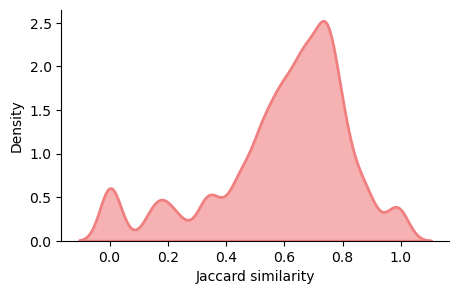

In [114]:

# Create a figure and axis
fig = plt.figure(figsize=(5, 3))
ax = plt.gca()

# Plot KDEs with the specified styling
# sns.kdeplot(prompt_correct_frac_list, color="blue", shade=True, label="Prompt based", ax=ax, lw=2, linestyle="-", alpha=0.6)
# sns.kdeplot(llm_performance_list, color="lightcoral", shade=True, label="KG-RAG based", ax=ax, lw=2, linestyle="-", alpha=0.6)
sns.kdeplot(llm_performance_list, color="lightcoral", shade=True, label="KG-RAG based", ax=ax, lw=2, linestyle="-", alpha=0.6, bw_method=0.15)
# sns.histplot(llm_performance_list, bins=20, color="lightcoral", kde=False, element="step", common_norm=False, ax=ax)


# Set the outline color to black
for artist in ax.lines:
    artist.set_edgecolor("black")

# Add labels and legend
plt.xlabel("Jaccard similarity")
plt.ylabel("Density")
# plt.xlim(0, 1)
# plt.legend(loc='upper right', bbox_to_anchor=(0.72, 0.9))

sns.despine(top=True, right=True)

# Show the plot
plt.show()

# figure_folder_name = "drug_repurposing"
# fig_filename = "../../../data/analysis_results/figures/{}/drug_repurposing_performance_gpt_4.svg".format(figure_folder_name)
# fig.savefig(fig_filename, format='svg', bbox_inches='tight')


In [68]:
pattern = r'\{[^{}]*\}'

# Use re.findall to find all matching JSON objects in the text
json_strings = re.findall(pattern, row["llm_answer"])

for json_string in json_strings:
    print(json_string)

{(2S)-1-phenylpropan-2-amine}
